This notebook looks at stereochemsitry inconsistency between openeye and rdkit.  
All molecules were taken from DrugBank

### Relevant right now
A. pyramidal nitrogen  
B. solfoxides  

Everything else is not very relevant at this stage but I wrote up these notes for future reference.   

There are several issues:   
1. Inconsistent flagging
    `cmiles.utils.has_stereo_defined(molecule)` will return different values depending on the toolkit being used.
    
    Most cases involve molecules that openeye does not flag as missing stereo but rdkit does flag them.  
    
    **cases**   
    A. Metalporphyrins (rdkit flags metal as missing chirality, oe does not)  
    B. porphyrins (oe flags as bonds missing cis/trans, rdkit does not)  
    C. Metals (Tungsten, Antimony)  
    D. large molecules that seem to be symmetric (rdkit flags, oe does not flag)      
    E. Bridged systems where the constraints should restrict the chirality (rdkit flags, oe does not flag)    
    F. N(C)(C)(C)=O (rdkit flags, oe does not flag)   
    G. Trivanadate (rdkit flags, oe does not flag)
    
    
2. Even after reasonable stereo flags are assigned, `cmiles.utils.has_stereo_defined(molecule)` will still raise an error. These are also inconsistent between toolkits. 

    **cases**  
    A. porphoryins without metal complexed (oe flags, rdkit does not)  
    B. Fe-2 metal complexed to porphyrin (rdkit flags, rdkit does not)  
    C. Antimony (Sb) (oe flags, rdkit does not)  
    
    
3. Loss of stereo information.  
   When an isomeric SMILES is used to generate an rdkit molecule, the isomeric SMILES generated by rdkit from this molecule will be missing some specified stereochemistry from the original SMILES.
   
   **cases**    
   A. pyramidal nitrogen, bismuth and arsenic   
   B. Sulfoxides (`C[S@@H]=O`)  
   C. porphyrins  
   D. Vanadium    
   
   
4. Loss of stereo information when explicit hydrogens are added.  
    When an isomeric SMILES is read into rdkit, and then explicit hydrogens added, the stereo flag is lost
    
    **cases**      
    A. sulfoxides (`C[S@@H]=O`)   
    Before explicit Hs are added to the molecule, `cmiles.utils.has_stereo_defined(molecule)` will return True, but if explicit Hs are added, it will raise an error. When a new isomric SMILES is written out with explicit Hs, the stereochemistry is missing. 
   
    

In [12]:
from openeye import oechem
from cmiles.utils import has_stereo_defined
from rdkit import Chem
import pandas as pd
import oenotebook as oenb

In [13]:
# Code to demonstrate issue 1.
with open('../cmiles/tests/reference/inconsistent_missing_stereo.smi', 'r') as f:
    smiles = f.read()
    smiles = smiles.split('\n')[:-1]
for sm in smiles:
    oemol = oechem.OEMol()
    if not oechem.OESmilesToMol(oemol, sm):
        raise RuntimeError("Cannot parse {}".format(sm))
    rdmol = Chem.MolFromSmiles(sm)
    assert has_stereo_defined(oemol) != has_stereo_defined(rdmol)

/Users/chayastern/src/openforcefield/cmiles/cmiles/_cmiles_rd.py:296: UserWarning: Stereochemistry is unspecified. Problematic atoms [(3, 'C'), (8, 'C')], problematic bonds []
  problematic_atoms, problematic_bonds))
/Users/chayastern/src/openforcefield/cmiles/cmiles/_cmiles_rd.py:296: UserWarning: Stereochemistry is unspecified. Problematic atoms [(35, '[Fe]')], problematic bonds []
  problematic_atoms, problematic_bonds))
/Users/chayastern/src/openforcefield/cmiles/cmiles/_cmiles_rd.py:296: UserWarning: Stereochemistry is unspecified. Problematic atoms [(22, 'P')], problematic bonds []
  problematic_atoms, problematic_bonds))
/Users/chayastern/src/openforcefield/cmiles/cmiles/_cmiles_rd.py:296: UserWarning: Stereochemistry is unspecified. Problematic atoms [(9, 'C')], problematic bonds []
  problematic_atoms, problematic_bonds))
/Users/chayastern/src/openforcefield/cmiles/cmiles/_cmiles_rd.py:296: UserWarning: Stereochemistry is unspecified. Problematic atoms [(25, 'P')], problematic

,Molecule
0,
1,
2,
3,
4,
5,

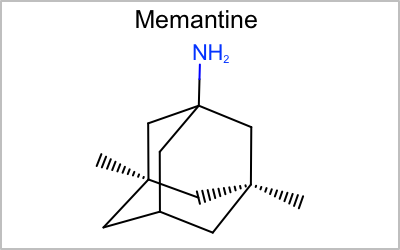
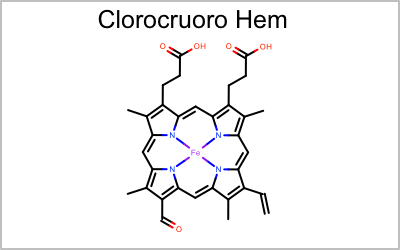
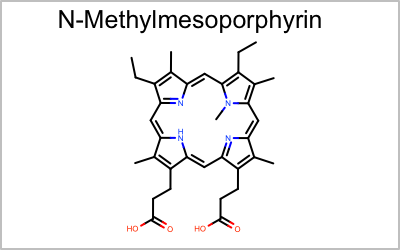
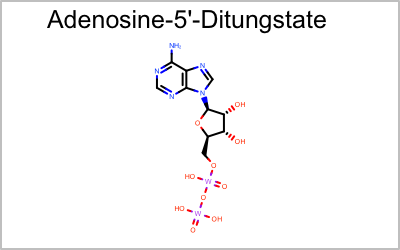
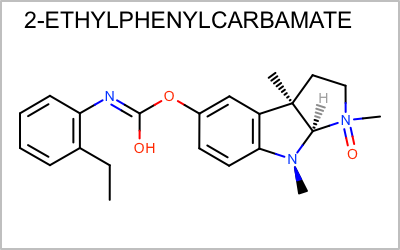
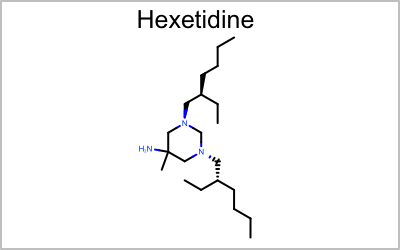

In [22]:
# Visualize relevant molecules
relevant_smiles = [smiles[i] for i in (0, 1, 6, 9, 29, 30)]
def to_molecule(smiles):
    oemol = oechem.OEMol()
    oechem.OESmilesToMol(oemol, smiles)
    return oemol
d = dict()
d['smiles'] = relevant_smiles
df = pd.DataFrame(d)
df['Molecule'] = df.smiles.apply(to_molecule)
df = df.drop(['smiles'], axis=1)
oenb.render_dataframe(df)

In [56]:
# Loss of stereo information for relevant molecules
loss_of_stereo = ['C[N@]1CCC[C@H]1c2cccnc2', #pyramidal nitrogen
                          'c1ccc2c(c1)C(=O)O[Bi@@](O2)O', #pyramidal bismuth
                          'C([C@@H](C(=O)O)N)S[As@@H]O', # pyramidal arsenic
                          'C([C@@H](C(=O)O)N)[S@@H]=O' # sulfoxide
                          ]
for sm in loss_of_stereo:
    oemol = oechem.OEMol()
    oechem.OESmilesToMol(oemol, sm)
    
    rdmol = Chem.MolFromSmiles(sm)
    print('Without explict H: {}'.format(has_stereo_defined(rdmol)))
    rdmol = Chem.AddHs(rdmol)
    print('With explict H: {}'.format(has_stereo_defined(rdmol)))
    sm_from_rd = Chem.MolToSmiles(rdmol)
    
    oemol_from_rd_sm = oechem.OEMol()
    oechem.OESmilesToMol(oemol_from_rd_sm, sm_from_rd)
    round_trip_smiles = oechem.OEMolToSmiles(oemol_from_rd_sm)
    
    new_oemol = oechem.OEMol()
    oechem.OESmilesToMol(new_oemol, round_trip_smiles)
    
    if has_stereo_defined(oemol) and not has_stereo_defined(new_oemol):
        print(sm)
        print('Without stereo:')
        print(round_trip_smiles, '\n ')

Without explict H: True
With explict H: True
C[N@]1CCC[C@H]1c2cccnc2
Without stereo:
CN1CCC[C@H]1c2cccnc2 
 
Without explict H: True
With explict H: True
c1ccc2c(c1)C(=O)O[Bi@@](O2)O
Without stereo:
c1ccc2c(c1)C(=O)O[Bi](O2)O 
 
Without explict H: True
With explict H: True
C([C@@H](C(=O)O)N)S[As@@H]O
Without stereo:
C([C@@H](C(=O)O)N)S[AsH]O 
 
Without explict H: True
With explict H: False
C([C@@H](C(=O)O)N)[S@@H]=O
Without stereo:
C([C@@H](C(=O)O)N)S=O 
 


,Molecule
0,
1,
2,
3,

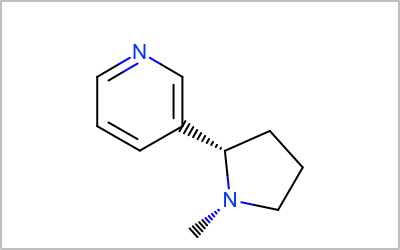
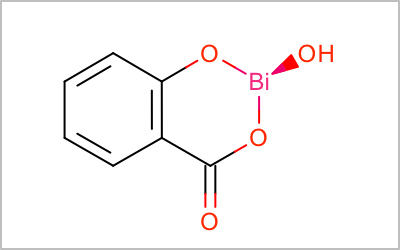
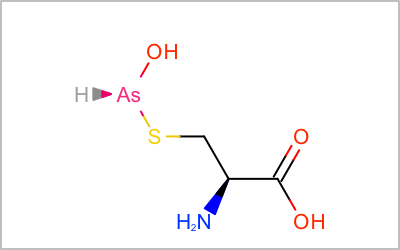
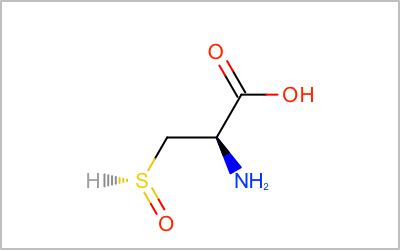

In [50]:
def to_molecule(smiles):
    oemol = oechem.OEMol()
    oechem.OESmilesToMol(oemol, smiles)
    return oemol
d = dict()
d['smiles'] = loss_of_stereo
df = pd.DataFrame(d)
df['Molecule'] = df.smiles.apply(to_molecule)
df = df.drop(['smiles'], axis=1)
oenb.render_dataframe(df)

 7 (5C-6C)
0
17 (14C-15C)
0
22 (18C-19C)
0


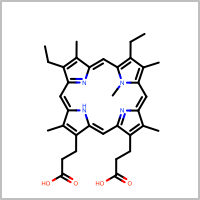

In [83]:
# poryphorins
smiles = 'CCC1=C(C)C2=CC3=C(CC)C(C)=C(C=C4N=C(C=C5N\C(=C/C1=N2)C(C)=C5CCC(O)=O)C(CCC(O)=O)=C4C)N3C'
mol = oechem.OEMol()
oechem.OESmilesToMol(mol, smiles)
def assign_bond_stereo(mol):
    for bond in mol.GetBonds():
        if bond.IsChiral() and not bond.HasStereoSpecified(oechem.OEBondStereo_CisTrans):
            print(bond)
            v = []
            for neigh in bond.GetBgn().GetAtoms():
                if neigh != bond.GetEnd():
                    v.append(neigh)
                    break
            for neigh in bond.GetEnd().GetAtoms():
                if neigh != bond.GetBgn():
                    v.append(neigh)
                    break
            stereo = bond.GetStereo(v, oechem.OEBondStereo_CisTrans)
            print(stereo)
            bond.SetStereo(v, oechem.OEBondStereo_CisTrans, oechem.OEBondStereo_Trans)
assign_bond_stereo(mol)
oenb.draw_mol(mol)

In [84]:
has_stereo_defined(mol)

True

In [85]:
new_smiles = oechem.OEMolToSmiles(mol)
new_mol = oechem.OEMol()
oechem.OESmilesToMol(new_mol, new_smiles)
has_stereo_defined(new_mol)

/Users/chayastern/src/openforcefield/cmiles/cmiles/_cmiles_oe.py:340: UserWarning: Stereochemistry is unspecified. Problematic atoms [], problematic bonds [(5, 'C', 6, 'C', 2), (9, 'C', 10, 'C', 2), (13, 'C', 15, 'C', 2), (18, 'C', 19, 'C', 2)]
  problematic_bonds))


False

In [86]:
assign_bond_stereo(new_mol)
has_stereo_defined(new_mol)

 7 (5C-6C)
0
12 (9C-10C)
0
18 (13C-15C)
0
23 (18C-19C)
0


True